# Assignment 3

Deadline: 09.04.2025 12:00 CET

<Add your name, student-id and emal address>

In [13]:

# Standard library imports
import os
import sys
import types

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course1\\src')
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_msci
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import MeanVariance
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_data_random,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
)
from backtesting.portfolio import floating_weights
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

### Data load

In [14]:
N = 24
data = load_data_msci(path = '../data/', n = N)  #<Change the path if needed>

### Prepare backtest service

In [15]:
# Define rebalancing dates
n_days = 21 * 3
start_date = '2010-01-01'
dates = data['return_series'].index
rebdates = dates[dates > start_date][::n_days].strftime('%Y-%m-%d').tolist()

# Define the selection item builders.
selection_item_builders = {
    'data': SelectionItemBuilder(
        bibfn = bibfn_selection_data_random,
        k = 10,
        seed = 42,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 365 * 3,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.5,
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    optimization = MeanVariance(
        covariance = Covariance(method = 'pearson'),
        expected_return = ExpectedReturn(method = 'geometric'),
        risk_aversion = 1,
        solver_name = 'cvxopt',
    ),
    rebdates = rebdates,
)

### Run the backtest

In [16]:
# Instantiate the backtest object and run the backtest
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs = bs)

Rebalancing date: 2010-01-04
Rebalancing date: 2010-04-01
Rebalancing date: 2010-06-29
Rebalancing date: 2010-09-24
Rebalancing date: 2010-12-22
Rebalancing date: 2011-03-21
Rebalancing date: 2011-06-16
Rebalancing date: 2011-09-13
Rebalancing date: 2011-12-09
Rebalancing date: 2012-03-07
Rebalancing date: 2012-06-04
Rebalancing date: 2012-08-30
Rebalancing date: 2012-11-27
Rebalancing date: 2013-02-22
Rebalancing date: 2013-05-22
Rebalancing date: 2013-08-19
Rebalancing date: 2013-11-14
Rebalancing date: 2014-02-11
Rebalancing date: 2014-05-09
Rebalancing date: 2014-08-06
Rebalancing date: 2014-11-03
Rebalancing date: 2015-01-29
Rebalancing date: 2015-04-28
Rebalancing date: 2015-07-24
Rebalancing date: 2015-10-21
Rebalancing date: 2016-01-18
Rebalancing date: 2016-04-14
Rebalancing date: 2016-07-12
Rebalancing date: 2016-10-07
Rebalancing date: 2017-01-04
Rebalancing date: 2017-04-03
Rebalancing date: 2017-06-29
Rebalancing date: 2017-09-26
Rebalancing date: 2017-12-22
Rebalancing da

## 1. Turnover

**(6 points)**

Complete the function `turnover`.

In [17]:
def turnover(self, return_series: pd.DataFrame, rescale: bool = True):
    dates = self.get_rebalancing_dates()
    to = {}
    if not dates:
        return pd.Series()
    to[dates[0]] = float(1)
    for rebalancing_date in dates[1:]:
        previous_portfolio = self.get_previous_portfolio(rebalancing_date)
        current_portfolio = self.get_portfolio(rebalancing_date)
        
        if current_portfolio.rebalancing_date is None or previous_portfolio.rebalancing_date is None:
            raise ValueError('Portfolios must have a rebalancing date')

        if current_portfolio.rebalancing_date < previous_portfolio.rebalancing_date:
            raise ValueError('The previous portfolio must be older than the current portfolio')

        # Get the union of the ids of the weights in both portfolios (previous and current)
        all_assets = set(previous_portfolio.weights.keys()).union(current_portfolio.weights.keys())
        
        # Extend the weights of the previous portfolio to the union of ids by adding zeros
        prev_weights_extended = {asset: previous_portfolio.weights.get(asset, 0.0) for asset in all_assets}
        
        # Float the previous portfolio's weights to the current rebalancing date
        floated_prev = floating_weights(
            X=return_series,
            w=prev_weights_extended,
            start_date=previous_portfolio.rebalancing_date,
            end_date=rebalancing_date,
            rescale=rescale
        ).iloc[-1]
        
        # Extract and extend the current portfolio's weights
        current_weights_extended = {asset: current_portfolio.weights.get(asset, 0.0) for asset in all_assets}
        current_series = pd.Series(current_weights_extended)
        
        # Calculate the turnover
        to[rebalancing_date] = (floated_prev - current_series).abs().sum()

    return pd.Series(to)

2: Simulation

(6 points)

Complete the function `simulate`.

In [18]:
def simulate(self,
             return_series: pd.DataFrame,
             fc: float = 0,
             vc: float = 0,
             n_days_per_year: int = 252) -> pd.Series:

    rebdates = self.get_rebalancing_dates()
    ret_list = []

    for rebdate in rebdates:
        next_rebdate = (
            rebdates[rebdates.index(rebdate) + 1]
            if rebdate < rebdates[-1]
            else return_series.index[-1]
        )

        portfolio = self.get_portfolio(rebdate)
        w_float = portfolio.float_weights(
            return_series=return_series,
            end_date=next_rebdate,
            rescale=False  # important: rescale is off here
        )
        level = w_float.sum(axis=1)
        ret_tmp = level.pct_change(1)
        ret_list.append(ret_tmp)

    portf_ret = pd.concat(ret_list).dropna()


    # Variable Cost
    if vc != 0:
        to = self.turnover(return_series=return_series, rescale=False)  # Series indexed by rebalance date

        # Apply variable cost to each rebalance day
        for date in to.index:
            if date in portf_ret.index:
                portf_ret.loc[date] -= vc * to.loc[date]

    # Fixed Cost
    if fc != 0:
        # Loop over rebalance periods and subtract daily fixed cost
        for i, rebdate in enumerate(rebdates):
            start = pd.to_datetime(rebdate)
            end = (
                pd.to_datetime(rebdates[i + 1])
                if i < len(rebdates) - 1
                else return_series.index[-1]
            )

            # Get date range within this rebalancing window
            mask = (portf_ret.index > start) & (portf_ret.index <= end)
            n_days = mask.sum()
            if n_days > 0:
                daily_fc = fc / n_days_per_year
                portf_ret.loc[mask] -= daily_fc

    return portf_ret


Overwrite the turnover and the simulation methods of the current strategy object.

In [19]:
# Overwrite the turnover method of the strategy object
bt_mv.strategy.turnover = types.MethodType(turnover, bt_mv.strategy)

# Overwrite the simulate method of the strategy object
bt_mv.strategy.simulate = types.MethodType(simulate, bt_mv.strategy)

Calculate and plot the turnover.

<Axes: title={'center': 'Turnover'}>

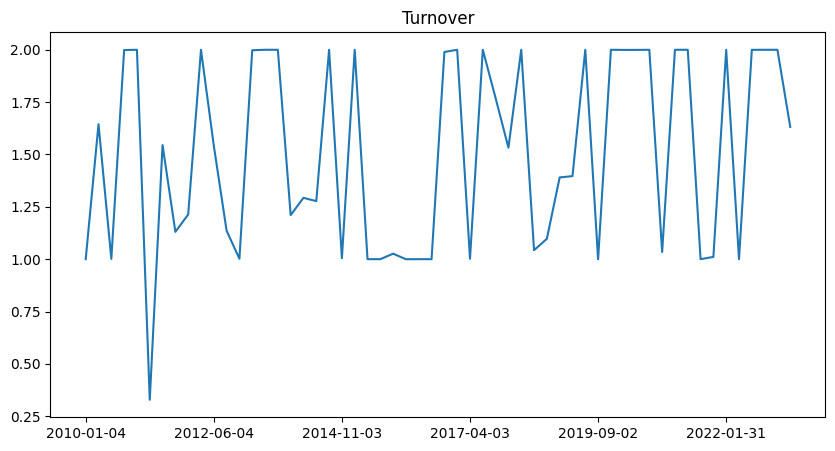

In [20]:
bt_mv.strategy.turnover(
    return_series = data['return_series'],
    rescale = True,
).plot(title = 'Turnover', figsize = (10, 5))


Simulate with different cost assumptions.

In [21]:
return_series = bs.data['return_series']

sim_mv_gross = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0)
sim_mv_net_of_fc = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0)
sim_mv_net_of_vc = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0.002)
sim_mv_net = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0.002)


Plot the cumulative returns.

<Axes: xlabel='Index'>

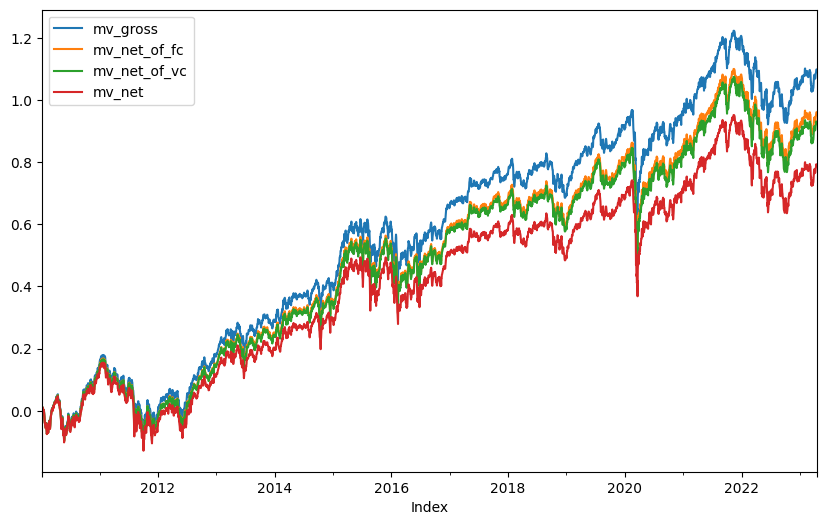

In [22]:
sim = pd.concat({
    'mv_gross': sim_mv_gross,
    'mv_net_of_fc': sim_mv_net_of_fc,
    'mv_net_of_vc': sim_mv_net_of_vc,
    'mv_net': sim_mv_net,
}, axis = 1).dropna()


np.log((1 + sim)).cumsum().plot(figsize = (10, 6))

3: Descriptive Statistics

(3 points)

Generate a table with descriptive statistics of the simulations. Include the following statistics:
- cumulative return (i.e., the return over the entire simulation period)
- annualized average returns
- annualized volatility
- sharpe ratio
- maximum drawdown

In [23]:
import pandas as pd
import numpy as np

# Set number of trading days per year
n_days_per_year = 252
risk_free_rate = 0.01  # 1% annual risk-free rate

# Create empty DataFrame to store the statistics
summary_stats = pd.DataFrame(index=sim.columns)

# Cumulative return
summary_stats['cumulative_return'] = (1 + sim).prod() - 1

# Annualized average return
summary_stats['annualized_return'] = (1 + sim).prod() ** (n_days_per_year / sim.shape[0]) - 1

# Annualized volatility
summary_stats['annualized_volatility'] = sim.std() * np.sqrt(n_days_per_year)

# Sharpe Ratio 
summary_stats['sharpe_ratio'] = (
    (summary_stats['annualized_return'] - risk_free_rate) / summary_stats['annualized_volatility']
)

# Maximum drawdown
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = cumulative / peak - 1
    return drawdown.min()

summary_stats['max_drawdown'] = sim.apply(max_drawdown)

# Display the table
import matplotlib.pyplot as plt
import seaborn as sns

# Print stats table
print(summary_stats)


              cumulative_return  annualized_return  annualized_volatility  \
mv_gross               1.997802           0.083095               0.147436   
mv_net_of_fc           1.612675           0.072321               0.147436   
mv_net_of_vc           1.530690           0.069838               0.147556   
mv_net                 1.205558           0.059195               0.147556   

              sharpe_ratio  max_drawdown  
mv_gross          0.495776     -0.307494  
mv_net_of_fc      0.422698     -0.308136  
mv_net_of_vc      0.405527     -0.310316  
mv_net            0.333399     -0.310955  
